### **Install packages and download the 2020 Deep Learning Track data**

In [1]:
!apt install libomp-dev
!pip install faiss-gpu --upgrade
!wget -c https://www.dropbox.com/s/m1n2wf80l1lb9j1/collection.tar.gz?dl=1 -O - | tar -xz
!wget https://raw.githubusercontent.com/castorini/anserini/master/src/main/resources/topics-and-qrels/topics.dl20.txt
!wget https://raw.githubusercontent.com/castorini/anserini/master/src/main/resources/topics-and-qrels/qrels.dl20-passage.txt
!pip install git+https://github.com/pedrogengo/pygaggle.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 2s (130 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

### **Get codes from github**

In [2]:
!git clone https://{getpass.getpass()}@github.com/leobavila/ia376e_projeto_final.git

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `git clone https://{getpass.getpass()}@github.com/leobavila/ia376e_projeto_final.git'


### **Mount Google Drive**

In [3]:
#google drive connection
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### **Import packages**

In [5]:
import argparse
import collections
import torch
import json
import pandas as pd
from pygaggle.rerank.base import Query, Text
from pygaggle.rerank.transformer import DuoT5
from transformers import T5ForConditionalGeneration
from tqdm import tqdm
from typing import List
import time

2021-12-07 22:39:49 [INFO] loader: Loading faiss with AVX2 support.
2021-12-07 22:39:49 [INFO] loader: Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2021-12-07 22:39:49 [INFO] loader: Loading faiss.
2021-12-07 22:39:49 [INFO] loader: Successfully loaded faiss.


**TREC Deep Learning Track 2020:**

* 8841823 text passages
* 200 queries
* 54 judged queries
* grades from 0 to 3

#### collection.tsv: file containing text passages and ids

In [6]:
# rows number
!wc -l collection.tsv

8841823 collection.tsv


In [7]:
# file sample
!head -n  5 collection.tsv

0	The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.
1	The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science.
2	Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it known that something this powerful can be manmade.
3	The Manhattan Project was the name for a project conducted during World War II, to develop the first atomic bomb. It refers specifically to the period of the project from 194 â¦ 2-1946 under the control of the U.S. Army Corps of Engineers

#### qrels.dl20-passage.txt: file containing a mapping of judged passages and queries

In [8]:
# rows number
!wc -l qrels.dl20-passage.txt

11386 qrels.dl20-passage.txt


In [9]:
# file sample: format (query 0 document judgement)
!head -n  5 qrels.dl20-passage.txt

23849 0 1020327 2
23849 0 1034183 3
23849 0 1120730 0
23849 0 1139571 1
23849 0 1143724 0


In [ ]:
# query 0 document judgement
!tail -n  5 qrels.dl20-passage.txt

1136962 0 8526087 0
1136962 0 8537921 0
1136962 0 8742482 0
1136962 0 937258 1
1136962 0 999215 0


In [10]:
df = pd.read_csv('qrels.dl20-passage.txt', header = None, sep = " ", names = ["query_id", "0", "doc_id", "relevance"])

In [11]:
df[['query_id', 'doc_id']].groupby('query_id').count().describe()

,doc_id
count,54.000000
mean,210.851852
std,56.358156
min,152.000000
25%,168.000000
50%,199.500000
75%,222.000000
max,368.000000


In [12]:
df["relevance"].describe()

count    11386.000000
mean         0.519761
std          0.877076
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: relevance, dtype: float64

#### topics.dl20.txt: file containing queries queries and ids

In [13]:
# rows
!wc -l topics.dl20.txt

200 topics.dl20.txt


In [14]:
# file sample
!head -n  5 topics.dl20.txt

1030303	who is aziz hashim
1037496	who is rep scalise?
1043135	who killed nicholas ii of russia
1045109	who owns barnhart crane
1049519	who said no one can make you feel inferior


### **MonoT5 Output**

**TREC Eval Format:**

* qid: is the query number
* Q0: is the literal Q0
* docno: is the id of a document returned for qid
* rank: is the rank of this response for this qid
* score: is a system-dependent indication of the quality of the response
* tag: is the identifier for the system

Reference: https://github.com/joaopalotti/trectools

In [ ]:
# query_id, Q0, doc_title, rank, _, _
!head -n 10 ../results/base.dl20.p.dTq.rm3.mono.trec

23849 Q0 2647769 1 0.9961765163553628 T5
23849 Q0 8010561 2 0.991423014586288 T5
23849 Q0 1944730 3 0.9693245316226593 T5
23849 Q0 6667419 4 0.8962516231336204 T5
23849 Q0 188190 5 0.8940519128636203 T5
23849 Q0 8059826 6 0.8647680858731489 T5
23849 Q0 3878669 7 0.8624387148939502 T5
23849 Q0 7119957 8 0.8577682299901036 T5
23849 Q0 2209883 9 0.7825795210210243 T5
23849 Q0 1622747 10 0.7427018424852081 T5


#### monoT5 output eval:

In [23]:
!python -m pyserini.eval.trec_eval \
    -c \
    -l 2 \
    -m ndcg_cut.10,20 \
    -m map \
    -m P.20,30 \
    -m recall.100,1000 \
    -m recip_rank \
    ./qrels.dl20-passage.txt \
    "./drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.mono.trec"

2021-12-07 23:01:54.733693: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
Running command: ['java', '-jar', '/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar', '-c', '-l', '2', '-m', 'ndcg_cut.10,20', '-m', 'map', '-m', 'P.20,30', '-m', 'recall.100,1000', '-m', 'recip_rank', './qrels.dl20-passage.txt', './drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.mono.trec']
Results:
map                   	all	0.4997
recip_rank            	all	0.8569
P_20                  	all	0.4222
P_30                  	all	0.3444
recall_100            	all	0.7513
recall_1000           	all	0.8699
ndcg_cut_10           	all	0.7048
ndcg_cut_20           	all	0.6808



In [20]:
!python "./drive/MyDrive/Projeto Final/ia376e_projeto_final/codes/measure_judged.py" \
    --qrels=./qrels.dl20-passage.txt \
    --run="./drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.mono.trec" \
    --cutoffs 10 20 \
    --topics-in-qrels-only

judged_cut_10	all	0.9926
judged_cut_20	all	0.8963


**Resultados Rodrigo:**

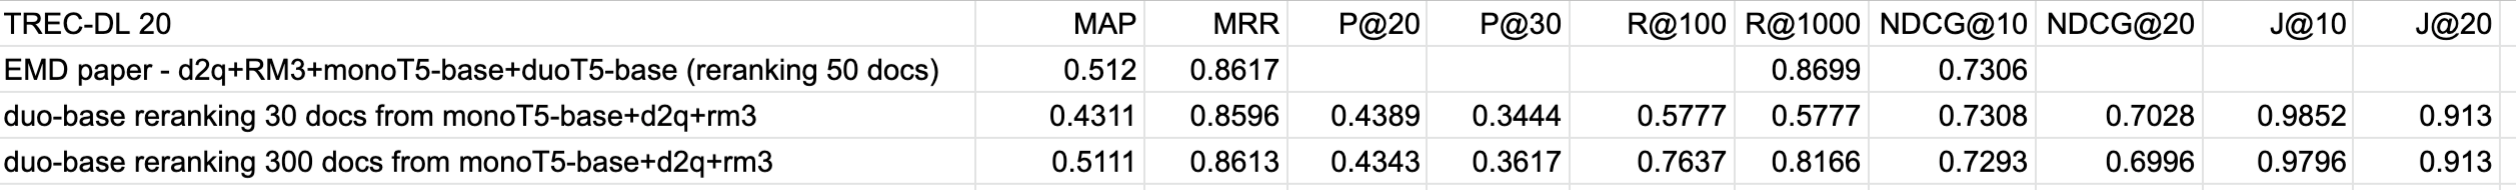

* Na segunda linha são os resultados do artigo anexo (Table 2, row (14)). Lá, o duoT5 reranqueia 50 documentos.
* Na terceira linha são os resultados que consegui reranqueando 30 documentos.
* E na quarta linha são os resultados reranqueando 300 documentos.

### **Reranking**

Code to rerank monoT5 output using a duoT5 model. The pyggagle code to run it was modified so we can obtain the pairwise_scores during the process.

The former pyggagle code uses a sym_sum aggregation function to calculate the pointwise_scores.

The pairwise_scores are important so we can test a bunch of aggregation functions fastly.

In [24]:
# Setting parameters
num_rerank = 30 # candidates: 30, 50, 100, 300

# Dataset path
collection_tsv = './collection.tsv'
topics = './topics.dl20.txt'
input_run = './drive/MyDrive/Projeto Final/ia376e_projeto_final/results/base.dl20.p.dTq.rm3.mono.trec'

# Output path
output_run = f'./drive/My Drive/Colab Notebooks/base.dl20.p.dTq.rm3.duo.{num_rerank}.trec'

# Getting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
def load_run(path):
    """Loads run into a dict of key: query_id, value: list of candidate doc
    ids."""

    # We want to preserve the order of runs so we can pair the run file with
    # the TFRecord file.
    print('Loading run...')
    run = collections.OrderedDict()
    with open(path) as f:
        for line in tqdm(f):
            query_id, _, doc_title, rank, _, _ = line.split()
            if query_id not in run:
                run[query_id] = []
            run[query_id].append((doc_title, int(rank)))

    # Sort candidate docs by rank.
    print('Sorting candidate docs by rank...')
    sorted_run = collections.OrderedDict()
    for query_id, doc_titles_ranks in tqdm(run.items()):
        doc_titles_ranks.sort(key=lambda x: x[1])
        doc_titles = [doc_titles for doc_titles, _ in doc_titles_ranks]
        sorted_run[query_id] = doc_titles

    return sorted_run

In [ ]:
# load the duot5-base-marco model
model = T5ForConditionalGeneration.from_pretrained('castorini/duot5-base-msmarco').to(device).eval()
reranker = DuoT5(model=model)
print(f'Running on {device}')

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Running on cuda


In [ ]:
# load the queries into a dictionary
queries = {}
with open(topics) as f:
    for line in f:
        query_id, query_text = line.strip().split('\t')
        queries[query_id] = query_text

In [ ]:
# load the collection into a dictionary
collection = {}
with open(collection_tsv) as f:
    for line in f:
        doc_id, doc_text = line.strip().split('\t')
        collection[doc_id] = doc_text

In [ ]:
# load the queries and its monoT5 results sorted by rank into a dictionary
run = load_run(path=input_run)

4027it [00:00, 23669.34it/s]

Loading run...


54000it [00:00, 211186.07it/s]
100%|██████████| 54/54 [00:00<00:00, 6760.77it/s]

Sorting candidate docs by rank...


In [ ]:
# reranking
query_scores = dict()
with open(output_run, 'w') as fout:
    for query_id, doc_ids in tqdm(run.items(), total=len(run)):
        
        query = Query(queries[query_id])
        doc_ids = doc_ids[:num_rerank]
        texts = [Text(collection[doc_id], {'docid': doc_id}, 0) for doc_id in doc_ids]
        agg_scores, pairwise_scores = reranker.rescore(query, texts)
        query_scores[query_id] = pairwise_scores
        reranked = sorted(agg_scores, key=lambda x: x.score, reverse=True)
        for rank, doc in enumerate(reranked, start=1): 
            fout.write(f'{query_id} Q0 {doc.metadata["docid"]} {rank} {doc.score} duo\n')
print('Done!')

  2%|▏         | 1/54 [01:25<1:15:25, 85.38s/it]


KeyboardInterrupt: ignored

In [ ]:
# create the json file containing the pairwise_scores
json.dump(query_scores, open(f'./drive/My Drive/Colab Notebooks/output_duot5_pairwise_scores_{num_rerank}.json', 'w'))

In [ ]:
# the results calculated using the sym_sum aggregation function are the the trec format:
# query_id, Q0, doc_title, rank, scores, model
!head -n 10 "./drive/My Drive/Colab Notebooks/base.dl20.p.dTq.rm3.duo.{num_rerank}.trec"

23849 Q0 2647769 1 197.15437763524005 duo
23849 Q0 8010561 2 195.99768596756348 duo
23849 Q0 1944730 3 188.82878314726258 duo
23849 Q0 5554704 4 185.5332758876566 duo
23849 Q0 188190 5 180.15709409584815 duo
23849 Q0 7119957 6 175.6568123752695 duo
23849 Q0 8059826 7 173.4208802893263 duo
23849 Q0 2017213 8 169.47239691516643 duo
23849 Q0 6667419 9 167.73268856753566 duo
23849 Q0 3113004 10 166.68141614428896 duo


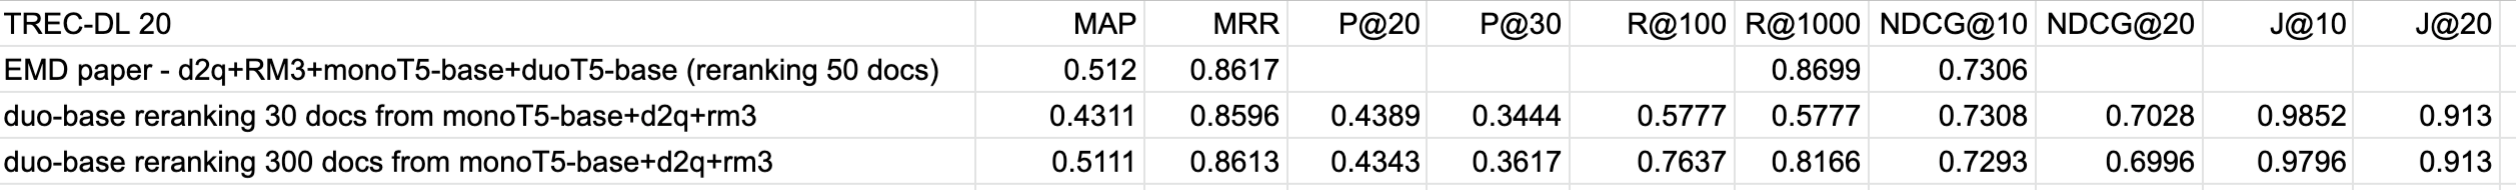

In [ ]:
!python -m pyserini.eval.trec_eval \
    -c \
    -l 2 \
    -m ndcg_cut.10,20 \
    -m map \
    -m P.20,30 \
    -m recall.100,1000 \
    -m recip_rank \
    ./qrels.dl20-passage.txt \
    "./drive/My Drive/Colab Notebooks/base.dl20.p.dTq.rm3.duo.{num_rerank}.trec"

In [ ]:
!python "./drive/MyDrive/Projeto Final/ia376e_projeto_final/codes/measure_judged.py" \
    --qrels=./qrels.dl20-passage.txt \
    --run="./drive/My Drive/Colab Notebooks/base.dl20.p.dTq.rm3.duo.{num_rerank}.trec" \
    --cutoffs 10 20 \
    --topics-in-qrels-only